In [10]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

## Load Data

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
SEED = 42

df = pd.read_csv("../data/creditcard.csv")
X_raw = df.drop("Class", axis=1)
y = df["Class"]

## Split Data

In [12]:
X_temp, X_test_raw, y_temp, y_test = train_test_split(
    X_raw, y, test_size=0.2, stratify=y, random_state=SEED)

X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, stratify=y_temp, random_state=SEED)

## Apply preprocessing Pipeline

In [13]:
from src.preprocessing import build_preprocessing_pipeline

pipeline = build_preprocessing_pipeline()
X_train = pipeline.fit_transform(X_train_raw)
X_val = pipeline.transform(X_val_raw)
X_test = pipeline.transform(X_test_raw)

### Save Trained Pipeline

In [14]:
import joblib, json

joblib.dump(pipeline, "../models/pipeline.pkl")
with open("../models/feature_names.json", "w") as f:
    json.dump(X_train_raw.columns.tolist(), f)

## Apply SMOTE to Training Data

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=SEED)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Train Model

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=SEED)
rf.fit(X_train_smote, y_train_smote)

joblib.dump(rf, "../models/rf_model.pkl")

['../models/rf_model.pkl']

## Threshold Tuning and Model Evaluation


RF Final — Best F1 at threshold 0.50
Precision: 0.9118, Recall: 0.7848, F1: 0.8435


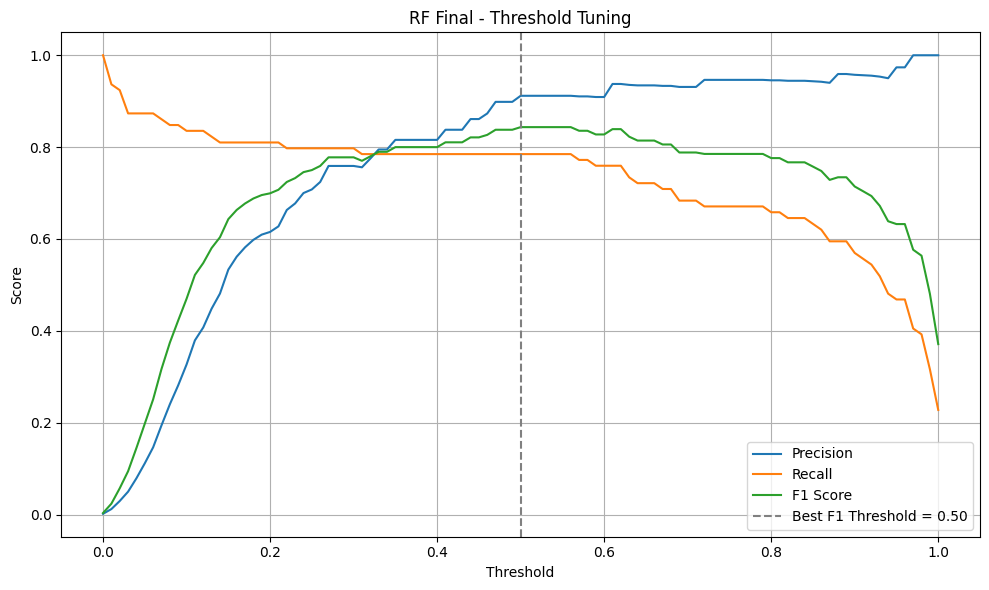

In [17]:
from src.utils import tune_thresholds

y_val_proba = rf.predict_proba(X_val)[:, 1]
best_threshold = tune_thresholds(y_val, y_val_proba, model_name="RF Final")

with open("../models/threshold.json", "w") as f:
    json.dump({"threshold": best_threshold}, f)

In [18]:
from sklearn.metrics import classification_report, average_precision_score

y_test_proba = rf.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_proba >= best_threshold).astype(int)

print(classification_report(y_test, y_test_pred))
print("PR AUC:", average_precision_score(y_test, y_test_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.82      0.87        98

    accuracy                           1.00     56962
   macro avg       0.96      0.91      0.93     56962
weighted avg       1.00      1.00      1.00     56962

PR AUC: 0.8599283004682969


## Save Predictions

In [19]:
pred_df = X_test_raw.copy()
pred_df["actual"] = y_test.values
pred_df["predicted"] = y_test_pred
pred_df["fraud_proba"] = y_test_proba

pred_df.to_csv("../data/test_predictions.csv", index=False)

## Final Model Summary

### Model Configuration
- **Algorithm:** RandomForestClassifier (n_estimators=100)
- **Preprocessing:** 
  - Log-transform on `Amount`
  - Cyclic encoding on `Time` (hour-based)
  - StandardScaler
- **Imbalance Handling:** SMOTE applied to training set only
- **Threshold Tuning:** Based on validation F1 score

### Selected Threshold
- **Optimal Threshold:** 0.50 (maximized F1 on validation set)
- **Validation Performance at Threshold 0.50:**
  - Precision: 0.9118
  - Recall: 0.7848
  - F1 Score: 0.8435

---

### Final Evaluation on Test Set
- **PR AUC:** 0.860
- **Classification Report:**

| Class | Precision | Recall | F1-Score | Support |
|-------|-----------|--------|----------|---------|
| 0     | 1.00      | 1.00   | 1.00     | 56864   |
| 1     | 0.93      | 0.82   | 0.87     | 98      |

- **Accuracy:** 1.00  
- **Macro Avg F1:** 0.93  
- **Weighted Avg F1:** 1.00  

---

### Model Artifacts Saved
- `models/pipeline.pkl`
- `models/rf_model.pkl`
- `models/threshold.json`
- `models/feature_names.json`

Artifacts are now ready for deployment and inference via:
- `src/predict.py` — new data predictions
- `src/evaluate.py` — test set evaluation
- `app/streamlit_app.py` — interactive front-end

This notebook represents the final reproducible training and evaluation pipeline for the selected production model.